# Parcial: Curso Análisis Predictivo de Series Temporales

## Posgrado de Big Data

## Universidad ORT Uruguay

### Curso 2024 - 4/7/2024.

## Estudiante: (completar)

In [2]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import numpy as np
import statsmodels.api as sm
import pandas as pd

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

#### Funciones útiles

In [3]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.formula.api import ols

def ccf(x, y, max_lag, ax=None, **kwargs):
    lags = np.arange(-max_lag, max_lag + 1)

    backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
    forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
    ccf = np.r_[backwards[:-1], forwards]
    ylabel = "CCF"

    if ax is None:
        ax = plt.gca()
    
    ax.stem(lags, ccf, basefmt="k")
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    conf_level = 1.96 / np.sqrt(x.shape[0])
    ax.fill_between(lags,conf_level,-conf_level,alpha=0.25)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    
    return ax

def periodogram(x,sampling_frequency=1):

    """Función que calcula el periodograma y grafica.
    
    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    plt.plot(f,P);
    plt.xlabel("Frequency")
    plt.ylabel("Power")


def spectrum(x,sampling_frequency=1, nfreq=10):

    """Función que calcula las componentes más relevantes del periodograma.
    
    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    nfreq = np.minimum(nfreq,round(n/2)) #corto nfreq si la serie es muy corta!
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    index = np.argsort(P)[::-1] #ordeno P decreciente
    return pd.DataFrame({"Frecuencia" : f[index[0:nfreq]],"Potencia" : P[index[0:nfreq]]})

## Ejercicio 1

Se considera la serie `flu` de incidencia de muertes por gripe en Estados Unidos (en valores cada 10.000 habitantes). La serie se divide en train y test, sacando el año 1978 para test del modelo.

Se pide:

1. Discuta brevemente la serie, determinando tendencias y posibles estacionalidades. Analizar también la autocorrelación de la serie.

2. Realice el cambio de variable `log` para reducir los picos y la varianza de la serie.
   
3. Para la serie $x=\log(flu)$, realizar un ajuste lineal basado en tendencia y variables categóricas (dummy) indicando el mes. Observar si todos los meses son relevantes y justificar la elección de aquellos incluidos en el modelo final.

4. A los residuos del ajuste anterior, analice si es posible modelarlos mediante un proceso ARMA(p,q) adecuado. Justifique la elección del orden en cada caso y analice los residuos obtenidos y calcule el MSE obtenido.

5. Realizar una predicción *completa* para los años 1979 y 1980 usando el comando `fit.append` agregando los datos de test.
   
6. Combinando las prediciones del modelo lineal más la del ARMA(p,q) ajustado, y deshaciendo el cambio de variable, grafique la predicción en las variables originales.


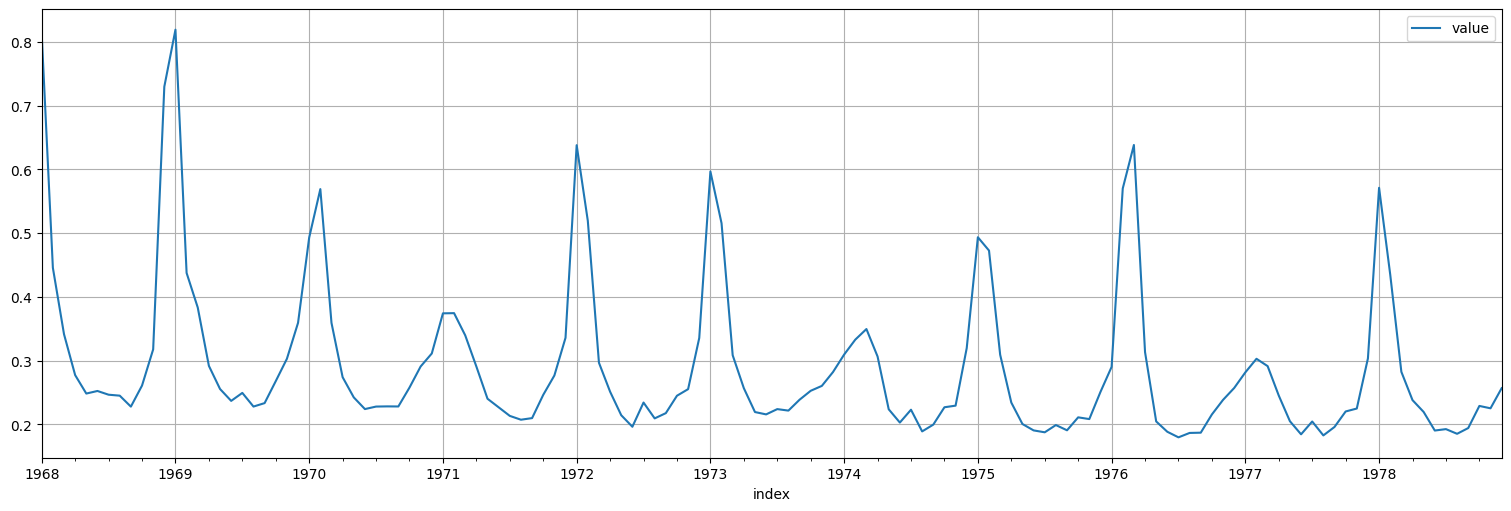

In [4]:
flu = astsa.flu
flu.plot();

## Ejercicio 2

Se considera la serie mensual de cobertura nubosa en el Lago Shatsa, California, incluida en la biblioteca `astsa`, en el objeto `climhyd`.

1. Realice un análisis por frecuencias de la serie.
2. Ajuste un modelo de tendencia lineal más frecuencias que considere adecuado. Elimine las variables no significativas.
3. Realice un análisis de los residuos obtenidos del ajuste (no seguir ajustando).
4. En el mismo objeto `climhyd`, se tiene la serie mensual de aportes o `Inflow` de agua al lago.
     1. Realice la transformación $\log$ a la serie inflow.
     2. Realice un estudio de la correlación cruzada entre ambas series.
     3. Proponga un modelo para predecir Inflow a partir del lag más significativo de cloud cover.

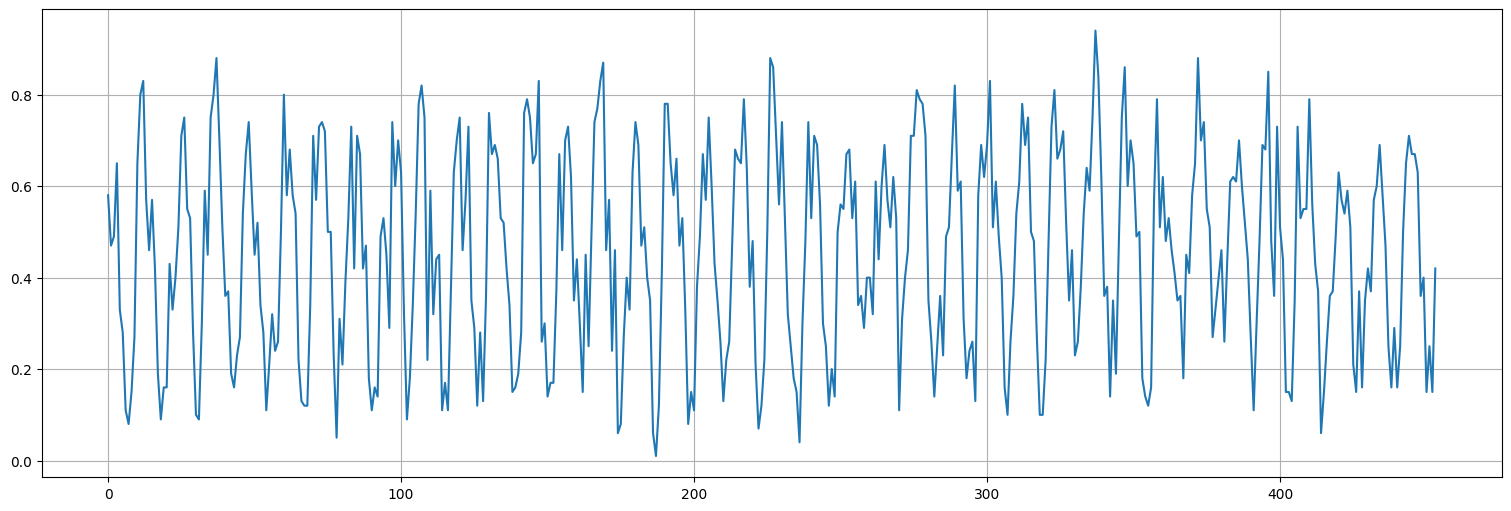

In [5]:
cloud = astsa.climhyd.CldCvr
cloud.plot();

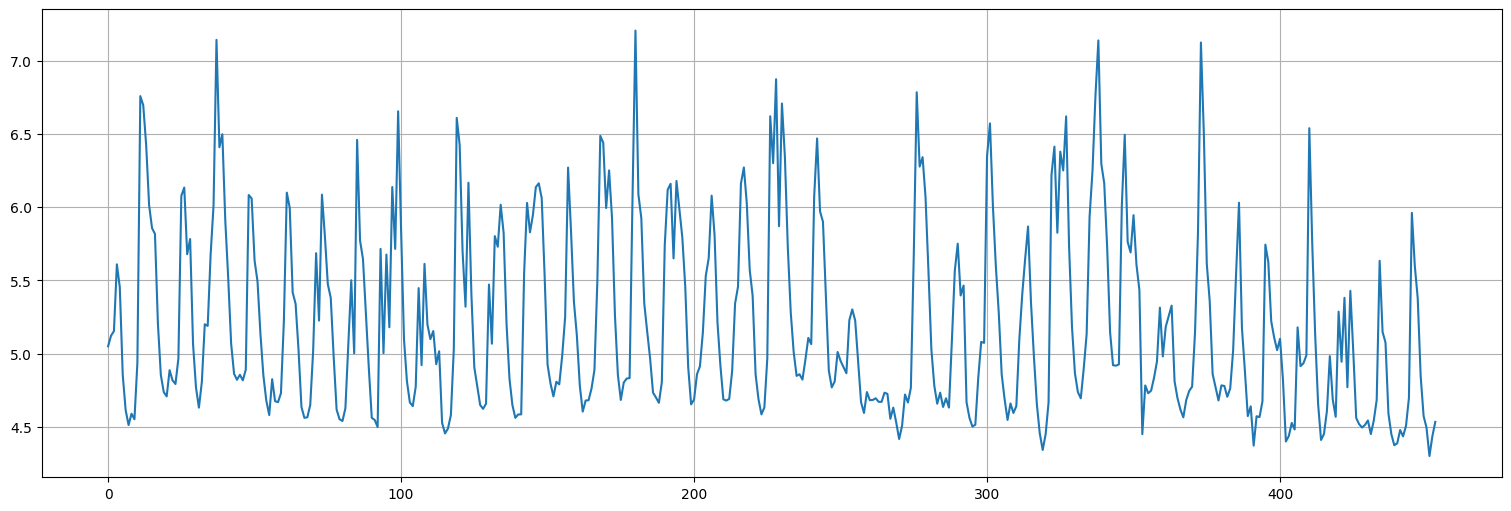

In [6]:
inflow = astsa.climhyd.Inflow
log_inflow = np.log(inflow)
log_inflow.plot();

## Ejercicio 3

Considere la serie de datos `casos` de incidencia de casos de Covid-19 en Uruguay. 

1. Aplique un modelo estructural de espacio de estados de tipo `UnobservedComponents` con componentes `level=True`, `stochastic_level=True` y `stochastic_seasonal=True` con frecuencia `seasonal=7`.
2. Graficar la tendencia central y la componente estacional obtenidas.

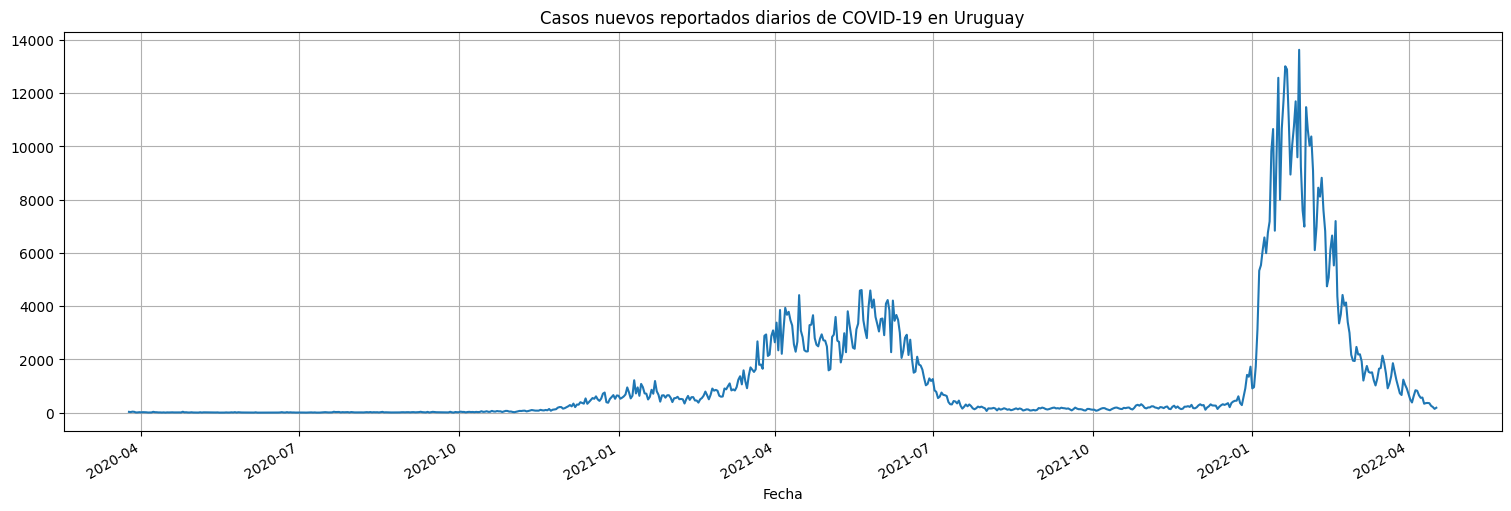

In [7]:
data = pd.read_csv("https://raw.githubusercontent.com/GUIAD-COVID/datos-y-visualizaciones-GUIAD/master/datos/estadisticasUY.csv", index_col=[0], parse_dates=[0], date_format="%d/%m/%Y")
casos = data["cantCasosNuevosAjustado"]
casos.plot(xlabel="Fecha", title="Casos nuevos reportados diarios de COVID-19 en Uruguay");